# Lesson 1: Computer Vision

## Research Question: How effectively can we use computer vision to discern human emotion from images?

In [1]:
# Define a function for retrieving img urls from DuckDuckGo
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        results = ddgs.images(term)
        images = [next(results).get("image") for _ in range(max_images)]
        return L(images)

Let's download and show an image of a happy person

Searching for 'happy person'


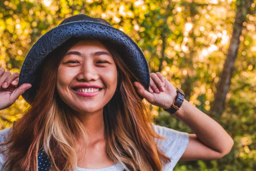

In [5]:
from fastdownload import download_url
from fastai.vision.all import *

dest = "happy.jpeg"
urls = search_images('happy person', max_images=1)
download_url(urls[0], dest)

im = Image.open(dest)
im.to_thumb(256,256)

Now we will do the same with a sad person photo

Searching for 'sad person'


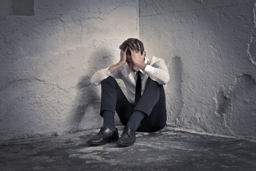

In [16]:
download_url(search_images('sad person', max_images=1)[0], 'sad.jpeg')
Image.open('sad.jpg').to_thumb(256,256)

Now that we have demonstrated the ability to retrieve both happy and sad images, let's build a dataset by pulling multiple happy and sad photos and labeling them accordingly.

In [8]:
searches = 'happy person','sad person'
path = Path('happy_or_sad')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} face photo'))
    sleep(10)

Searching for 'happy person photo'
Searching for 'happy person face photo'
Searching for 'sad person photo'
Searching for 'sad person face photo'


Some photos might not download correctly which could cause our model training to fail, so we'll remove them

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

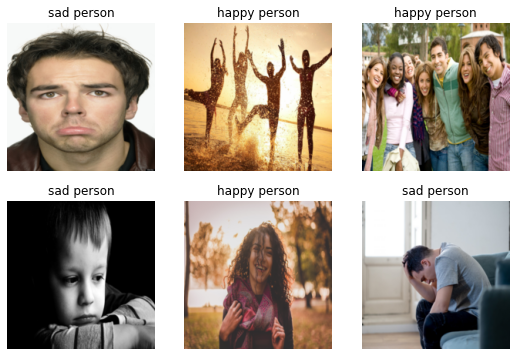

In [34]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [35]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.662068,2.899933,0.476190,00:24


epoch,train_loss,valid_loss,error_rate,time
0,1.019184,1.938412,0.476190,00:26
1,0.686228,1.171197,0.333333,00:26
2,0.559834,0.664045,0.238095,00:26


In [36]:
is_happy,_,probs = learn.predict(PILImage.create('sad.jpeg'))
print(f"This is a: {is_happy}.")
print(f"Probability person is happy: {probs[0]:.4f}")

This is a: sad person.
Probability person is happy: 0.0486


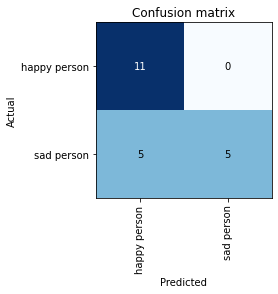

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

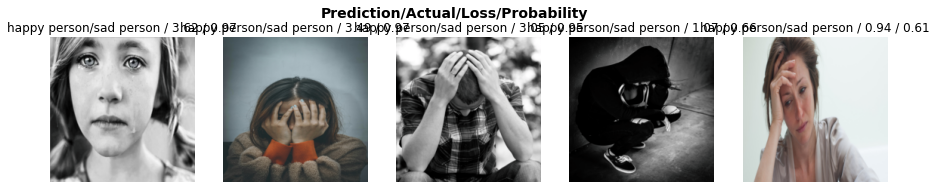

In [38]:
interp.plot_top_losses(5, nrows=1)

In [39]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [40]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

Now we will retrain the dataset with the updated data

In [42]:
dls2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

In [43]:
learn2 = vision_learner(dls2, resnet18, metrics=error_rate)
learn2.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.530080,4.172669,0.476190,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.845145,2.505183,0.476190,00:26
1,0.585517,1.030743,0.428571,00:27
2,0.450013,0.546899,0.238095,00:26


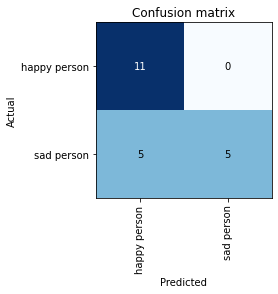

In [44]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix()

The cleaning of the data did not increase the accuracy.

In [45]:
# We can export our model with the following command
# learn2.export()